In [1]:
import pennylane as qml
from pennylane import numpy as np
import autograd.numpy as np_grad
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score
import math

In [8]:
from pennylane.templates import AmplitudeEmbedding

dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit_qml(feature=None, params=None):
    AmplitudeEmbedding(features=initial_state(feature), wires=range(2))
    for i in range(len(params)):
        qml.RX(params[i][0], wires=0)
        qml.RY(params[i][1], wires=0)
        qml.RX(params[i][2], wires=1)
        qml.RY(params[i][3], wires=1)
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 0])
        basis_state=np.array([1])
    return qml.expval(qml.Projector(basis_state, wires=[0])), qml.expval(qml.Projector(basis_state, wires=[1]))

# activation function
def sigmoid(x):
    return 1 / (1 + np_grad.exp(-10*x))

def predict(feature, params):
    expval = circuit_qml(feature, params)
    pred = sigmoid(expval[0]-expval[1])
    return [pred, 1-pred]

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p[l]) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params):
    features, labels = X_train, y_train
    preds = [predict(x, params) for x in features]
    return square_loss(labels, preds)

# encoding the features
def initial_state(feature):
    ampli_vec = np_grad.array([np_grad.sqrt(feature[0]), np_grad.sqrt(1-feature[0])])
    for i in range(1, len(feature)):
        ampli_vec = np_grad.kron(ampli_vec, np.array([np_grad.sqrt(feature[i]), np_grad.sqrt(1-feature[i])]))
    return ampli_vec

In [9]:
# source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create parameters  
n_layer = 3
params = np_grad.zeros((n_layer, 4,))
params

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
cost(params)

tensor(0.39665848, requires_grad=True)

In [11]:
opt = qml.AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-6)
steps = 200
params = np_grad.zeros((n_layer, 4,))
costs = []

start = time.time()
for i in range(200):
    params, loss = opt.step_and_cost(cost, params)
    costs.append(loss)
end = time.time()

In [17]:
SIZE = 34*1.3
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)  # fontsize of the figure title

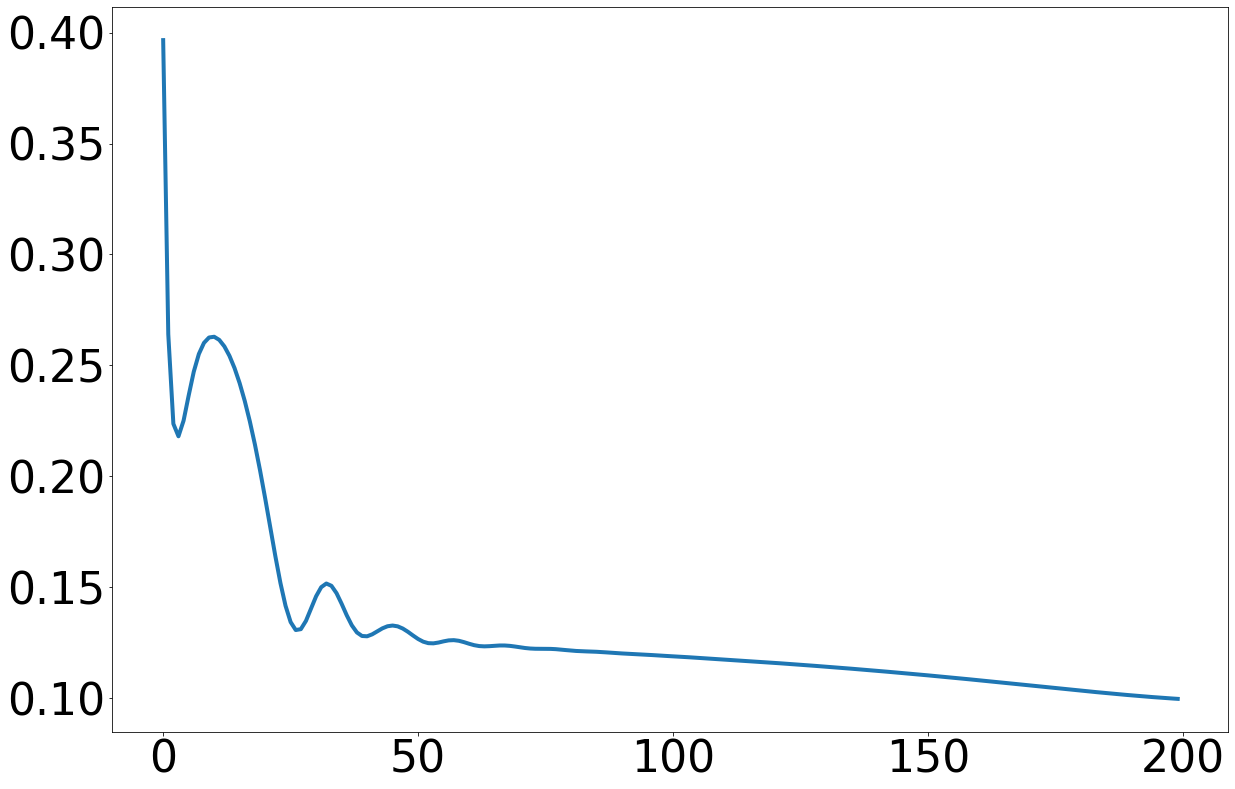

In [18]:
plt.figure(figsize=(20,13.33))
plt.plot(range(len(costs)), costs, linewidth=4)
plt.savefig('pennylane.png')


In [13]:
cost(params)

tensor(0.09947588, requires_grad=True)

In [14]:
end-start

723.3755519390106

In [15]:
pred = [predict(x, params) for x in X_train]
pred = np.argmax(pred, axis=1)

In [16]:
accuracy_score(y_train, pred)

0.878125

# Compare with Qsun

In [19]:
# import libraries
from Qsun.Qcircuit import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score

# one layer with full entanglement
def layer(circuit, params):
    circuit_layer = circuit
    n_qubit = len(params)
    for i in range(n_qubit):
        RX(circuit_layer, i, params[i][0])
        RY(circuit_layer, i, params[i][1])
    for i in range(n_qubit-1):
        CNOT(circuit_layer, i, i+1)
    CNOT(circuit_layer, n_qubit-1, 0)
    return circuit_layer

# encoding the features
def initial_state(sample):
    circuit_initial = Qubit(len(sample))
    ampli_vec = np.array([np.sqrt(sample[0]), np.sqrt(1-sample[0])])
    for i in range(1, len(sample)):
        ampli_vec = np.kron(ampli_vec, np.array([np.sqrt(sample[i]), np.sqrt(1-sample[i])]))
    circuit_initial.amplitude = ampli_vec
    return circuit_initial

# QNN circuit
def qnn(circuit, params):
    n_layer = len(params)
    circuit_qnn = circuit
    for i in range(n_layer):
        circuit_qnn = layer(circuit_qnn, params[i])
    return circuit_qnn

# QNN model
def qnn_model(sample, params):
    circuit_model = initial_state(sample)
    circuit_model = qnn(circuit_model, params)
    return circuit_model

# activation function
def sigmoid(x):
    return 1 / (1 + math.exp(-10*x))

# make a prediction
def predict(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    pred = sigmoid(expval_0-expval_1)
    return [pred, 1-pred]

# make a prediction for ex
def predict_ex(circuit):
    prob_0 = measure_one(circuit, 0)
    prob_1 = measure_one(circuit, 1)
    expval_0 = prob_0[1]
    expval_1 = prob_1[1]
    return [expval_0, expval_1]

# loss function    
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (1 - p[l]) ** 2
    loss = loss / len(labels)
    return loss

# loss function of QNN
def cost(params, features, labels):
    preds = [predict(qnn_model(x, params)) for x in features]
    return square_loss(labels, preds)

# gradient descent with QDP
def grad(X_true, y_true, params, shift, eta, drop_rate):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)                
    params -= eta*diff
                
    return params

# adagrad: https://d2l.ai/chapter_optimization/adagrad.html                        

def adagrad(X_true, y_true, params, s, shift, eta, drop_rate, eps):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    s += diff**2
    params -= eta*diff/np.sqrt(s+eps)
                
    return params, s

# https://d2l.ai/chapter_optimization/adam.html?highlight=adam

def adam(X_true, y_true, params, v, s, shift, eta, drop_rate, beta1, beta2, eps, iter_num):
    diff = np.zeros(params.shape)
    for i in range(len(params)):
        for j in range(len(params[i])):
            for k in range(len(params[i][j])):
                dropout = np.random.choice([0, 1], 1, p = [1 - drop_rate, drop_rate])[0]
                if dropout == 0:
                    params_1 = params.copy()
                    params_2 = params.copy()
                    params_1[i][j][k] += shift
                    params_2[i][j][k] -= shift
                    for x, y in zip(X_true, y_true):
                        circuit = qnn_model(x, params)
                        circuit_1 = qnn_model(x, params_1)
                        circuit_2 = qnn_model(x, params_2)
                        ex_plus = predict_ex(circuit_1)
                        ex_subs = predict_ex(circuit_2)
                        pred = predict(circuit)
                        diff_loss = ((-1)**y)*(-2)*(1-pred[y])*pred[y]*(1-pred[y])
                        diff_ex = 10*((ex_plus[0] - ex_subs[0]) - (ex_plus[1] - ex_subs[1]))/(2*np.sin(shift))
                        diff[i][j][k] += diff_loss*diff_ex
                                                
    diff /= len(y_true)
    v = beta1 * v + (1 - beta1) * diff
    s = beta2 * s + (1 - beta2) * (diff**2)
    v_bias_corr = v / (1 - beta1 ** (iter_num+1))
    s_bias_corr = s / (1 - beta2 ** (iter_num+1))
    params -= eta * v_bias_corr / (np.sqrt(s_bias_corr) + eps)
    
    return params, v, s

In [20]:
def qnn_training(X_true, y_true, params, max_ieration, shift=np.pi/20, eta=0.1, drop_rate=0.1, choice='grad'):
    if choice == 'grad':
        for k in range(max_ieration):
            params = grad(X_train, y_train, params, shift, eta, drop_rate)
    elif choice == 'adagrad':
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, s = adagrad(X_train, y_train, params, s, shift, eta, drop_rate, 1e-6)
    elif choice == 'adam':
        v = np.zeros(params.shape)
        s = np.zeros(params.shape)
        for k in range(max_ieration):
            params, v, s = adam(X_train, y_train, params, v, s, shift, eta, drop_rate, 0.9, 0.99, 1e-6, k)
    return params

In [21]:
#source: https://www.kaggle.com/rakeshrau/social-network-ads
dataset = pd.read_csv('Social_Network_Ads.csv')
X = dataset.iloc[:, 2:-1].values
y = dataset.iloc[:, -1].values

# splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# scaling feature
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
costs_train_qnn = []
costs_test_qnn = []
accuracy_train_qnn = []
accuracy_test_qnn = []

label_train = y_train
label_test = y_test

# training model
for l in range(3, 4):
    start = time.time()

    params = np.zeros((l, len(X_train[0]), 2,))
    v = np.zeros(params.shape)
    s = np.zeros(params.shape)
    
    costs_train = []
    costs_test = []
    accuracy_train = []
    accuracy_test = []

    for i in range(200):
        params, v, s = adam(X_train, y_train, params, v, s, 
                            shift=np.pi/20, eta=0.1, drop_rate=0.0, beta1=0.9, beta2=0.99, eps=1e-6, iter_num=i)

        pred_train = [predict(qnn_model(x, params)) for x in X_train]
        pred_train = np.argmax(pred_train, axis=1)

        pred_test = [predict(qnn_model(x, params)) for x in X_test]
        pred_test = np.argmax(pred_test, axis=1)

        costs_train.append(cost(params, X_train, y_train))
        costs_test.append(cost(params, X_test, y_test))
        accuracy_train.append(accuracy_score(label_train, pred_train))
        accuracy_test.append(accuracy_score(label_test, pred_test))
    
    costs_train_qnn.append(costs_train)
    costs_test_qnn.append(costs_test)
    accuracy_train_qnn.append(accuracy_train)
    accuracy_test_qnn.append(accuracy_test)
    
    #     if costs_train[-1] >= costs_train[-2]:
    #         break
    print(time.time()-start)

906.8000149726868


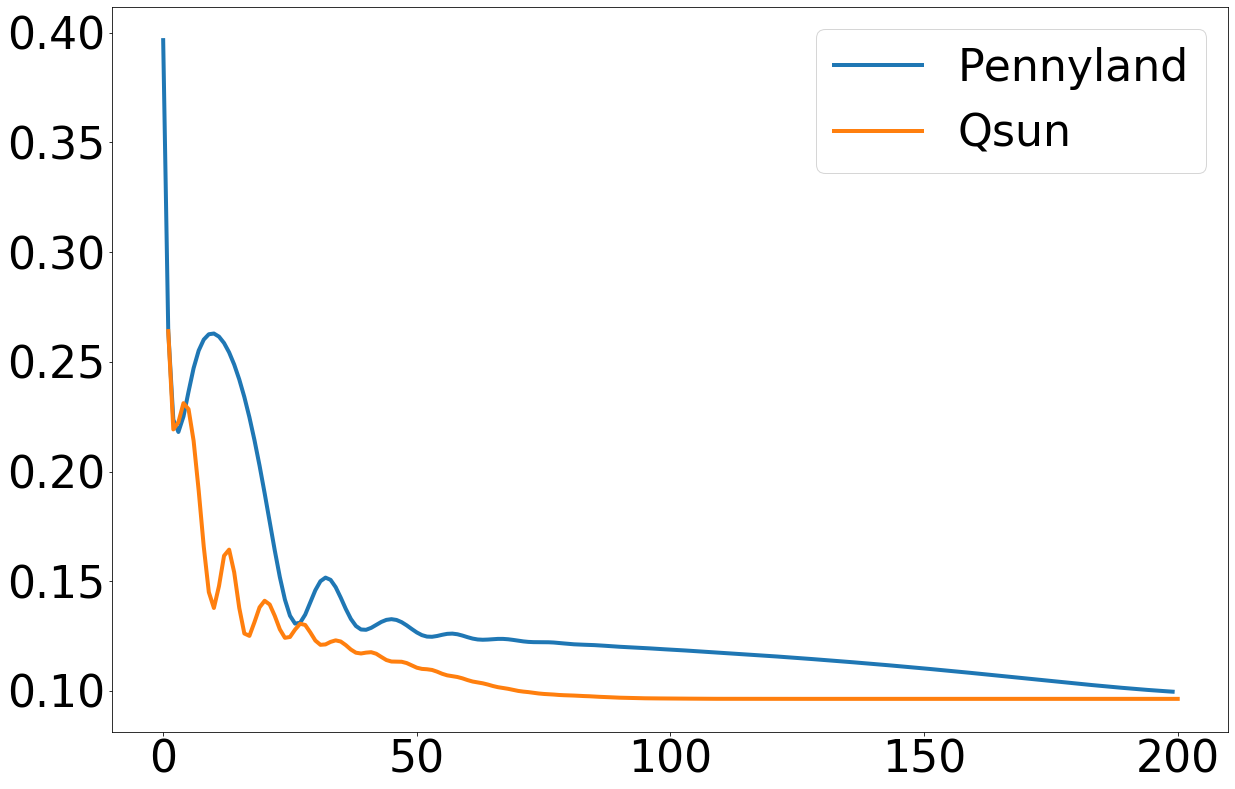

In [25]:
plt.figure(figsize=(20,13.33))
plt.plot(range(len(costs)), costs, linewidth=4, label='Pennyland')
plt.plot(range(1, len(costs_train_qnn[0])+1), costs_train_qnn[0], linewidth=4, label='Qsun')
plt.legend()
plt.savefig('pennylane.png')